In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt

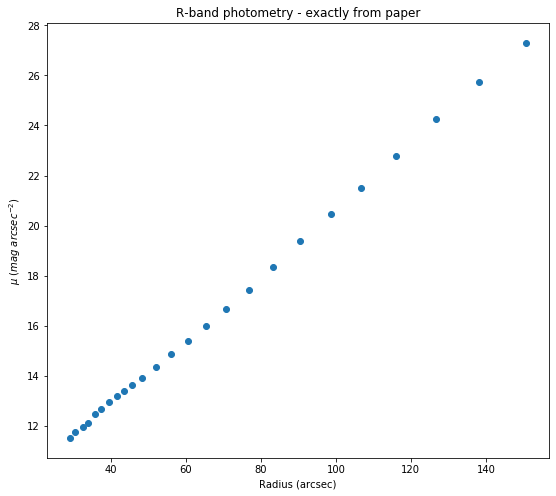

In [2]:
# According to Noordermeer's email: 
   # "For the contribution of the stars (bulge + disk), I used the 
   # R-band photometry published in Noordermeer & Van der Hulst (2007 - MNRAS 376; p1480). 
   # Again, I believe there was a tool (perhaps the same one as for the gas disk) 
   # in GIPSY to convert this into a rotation curve, but I'm afraid I can't recall the details."

# Used DataThief to get data from image
mudata = np.loadtxt("../data/nord-mu-disk.txt")
rarcsec, mu_magarcsec = mudata.T

mu0_d = 21.27                                               # disk central surface brightness in mag arcsec^-2

# Plot R-band photometry to make sure data was traced right
plt.figure(figsize=(9,8))
plt.scatter(rarcsec,mu_magarcsec)
plt.title("R-band photometry - exactly from paper")
plt.xlabel("Radius (arcsec)")
plt.ylabel("$\mu$ ($mag$ $arcsec^{-2}$)")
plt.show()

[166.30694364 169.82629322 172.73094705 175.12768327 180.02360501
 182.96433254 186.70301017 190.15309826 193.05775209 196.50784018
 201.04591087 207.14525103 214.62404925 222.35536333 230.59603797
 240.50620316 251.46827726 264.64239027 279.4484772  295.56187479
 310.26262653 328.5173586  349.74744893 371.16367953 393.88577785]
306.91498773920125


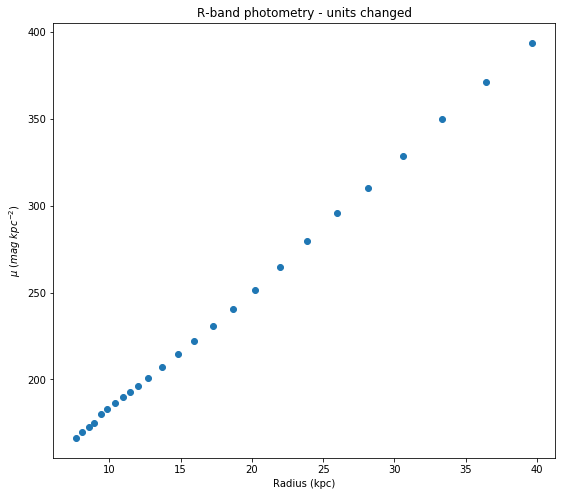

In [3]:
# Convert mag arcsec^-2 to mag kpc^-2
# First to degree: 1 degree = 3600 arcseconds
mu_degree = mu_magarcsec * 3600**2
# Then to radians: 1 radian = 180degree/Pi
mu_radians = mu_degree * (180/np.pi)**2
# Then to Mpc: 1 Mpc = 2*Pi*distance*angle(in degrees)/360degrees (source: https://www.astronomynotes.com/solarsys/s2.htm)
D = 54.3                                    # distance in Mpc
mu_Mpc = mu_radians / (D**2)
mu_kpc = mu_Mpc / (1000**2)
print(mu_kpc)

# Converting arcseconds to kpc for radius measurements
rkpc = rarcsec*D*1000/206265                # calculated using http://astro.physics.uiowa.edu/ITU/glossary/small-angle-formula/

# Convert disk central surface brightness - mag arcsec^-1 to mag kpc^-2
# First to degree: 1 degree = 3600 arcseconds
mu0d_degree = mu0_d * 3600**2
# Then to radians: 1 radian = 180degree/Pi
mu0d_radians = mu0d_degree * (180/np.pi)**2
# Then to Mpc: 1 Mpc = 2*Pi*distance*angle(in degrees)/360degrees (source: https://www.astronomynotes.com/solarsys/s2.htm)
mu0d_Mpc = mu0d_radians / (D**2)
mu0d_kpc = mu0d_Mpc / (1000**2)
print(mu0d_kpc)

# Plot R-band photometry with units changed
plt.figure(figsize=(9,8))
plt.scatter(rkpc,mu_kpc)
plt.title("R-band photometry - units changed")
plt.xlabel("Radius (kpc)")
plt.ylabel("$\mu$ ($mag$ $kpc^{-2}$)")
plt.show()

In [4]:
xdinp = rkpc
ydinp = mu0d_kpc

In [5]:
# Parameters for Galaxy NGC 5533
G = 0.00000431158              # gravitational constant (kpc/solar mass*(km/s)^2)
h = 8.9                        # radial scale-length (kpc)
dens0 = 0.31e9                 # central density of exponential DISK in solar masses per square parsec
dens0 = mu0_d

z0 = 0.2*h                     # scale height of DISK in kpc [0.0]. 
                               # note: The integration in Z is the most time consuming part
                               # of the calculation. For example it takes about 0.2 seconds
                               # to calculate a point on the rotation curve for a disk with zero
                               # thickness, and about 2 seconds for a disk with non-zero thickness.

rcut = 4*h                     # cutoff radius

delta = 0.2*h                  # softening parameter of DISK in kpc [0.0]. It may be wise
                               # to have a non-zero softening in case of a truncated disk, 
                               # because then the sharp features in the calculated rotation 
                               # curve will be smoothed out. A softening parameter of about 
                               # 0.2 scale lengths would be sufficient.
                
LEN1 = 20016
LEN2 = 40001

#LEN2 = len(rkpc)              
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 0.000001

naccur = 1                     # GUESS -> accuracy of calculations, range between 1-10, 
                               # The programme needs more time for higher accuracies. 
                               # If no ZLAW is specified, the accuracy parameter is always 10.

#radii = np.linspace(0,100,500)    # GUESS -> sampling radii
radii = rkpc                   # GUESS -> sampling radii
R = lambda h: 4*h

In [6]:
# Definitions
def func(x,y,z):
    xxx = (x*x + y*y + z*z) / (2.0 * x * y)
    rrr = (xxx*xxx - 1.0)
    ppp = 1.0 / (xxx + np.sqrt(rrr))
    fm = 1.0 - ppp*ppp
    el1 = (1.3862944 + fm * (0.1119723 + fm * 0.0725296)) - (0.5 + fm * (0.1213478 + fm * 0.0288729)) * np.log(fm)
    el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)
    r = ((1.0 - xxx * y/x) * el2 / (rrr) + (y/x - ppp) * el1 / np.sqrt(rrr)) / np.pi
    r *= np.sqrt(x / (y * ppp))
    return r

In [7]:
# DISK Density distribution 
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    r = r * r * z0
    r = 1.0 / r
    return r

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh (z / z0)
    return r

def denzed(z,z0):
    case = input("Which Z density law? 2 or 3 or 4: ")
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case2(z,z0)

In [8]:
"""intzed computes the integral over Z that defines the kernel of the integral formula for the rotation velocity. 
This is done for an arbitrary vertical density profile, specified in the function denzed.
The interval of integration is divided into several subintervals, in each of which Simpson's rule is used. 
It is thus possible to have different steps in different regions of the interval of integration, 
and to compute the integral more accurately. An attempt has been made at optimizing the subdivision. 
It is still possible that the kernel is not accurate, especially when R is very close to U. 
It is NOT recommended that the programme is used with very small, but non-zero, values of the thickness. 
On the other hand, the situation with an infinitely thin disk is dealt with properly, the density profile in 
Z being then treated as a Dirac delta function."""

def intzed(r,u,z,z0,naccur):
    zeds = np.array([0.02, 0.50, 1.00, 3.00, 10.00])
    
    if (z0 != 0.0 & naccur != 0):
        n = 10
        n = naccur * n
        
        if (np.abs(r - u) <= (0.2 * z0)) & (naccur > 1):
            n = 200
        
        zne = 0.0
        res = 0.0
        i = 0.0
        while i < 5: 
            zol = zne
            zne = zeds[i] * z0
            step = (zne - zol) / n
            z = zol
            res += step * func(r,u,z) * denzed(z,z0) / 3.0
            w = 4.0 / 3.0         
            j = 0.0
            while j < n:
                z += step
                res += step * func(r,u,z) * denzed(z,z0) * w
                w = 2.0 - w
                j += 1
            res -= step * func(r,u,z) * denzed(z,z0) / 3.0
            i += 1
    else:
        res = func(r,u,z0)
    return res

In [9]:
"""# interp does a Lagrange interpolation (second order)
def interpd(x1,y1,x2,y2):
    i = 0
    j = 1
    done = 0
    n1 = len(radii)
    n2 = len(radii)
    
    while i < n2:
        x = x2[i]
        y = 0.0
        while (j != done) & (j < (n1 - 1)):
            if ((x1[j-1] <= x ) & (x1[j+1] >= x)):
                k = j - 1
                while (k <= j + 1):
                    f = 1.0
                    l = j - 1
                    while l <= j + 1:
                        if (l != k):
                            f *= (x - x1[l]) / (x1[k] - x1[l])
                        l += 1        
                    y += f * y1[k]
                    k += 1 
                done = 1
            j += 1
        if (y > 0.0):
            y2[i] = y
        else: 
            y2[i] =0.0
        i += 1
"""

'# interp does a Lagrange interpolation (second order)\ndef interpd(x1,y1,x2,y2):\n    i = 0\n    j = 1\n    done = 0\n    n1 = len(radii)\n    n2 = len(radii)\n    \n    while i < n2:\n        x = x2[i]\n        y = 0.0\n        while (j != done) & (j < (n1 - 1)):\n            if ((x1[j-1] <= x ) & (x1[j+1] >= x)):\n                k = j - 1\n                while (k <= j + 1):\n                    f = 1.0\n                    l = j - 1\n                    while l <= j + 1:\n                        if (l != k):\n                            f *= (x - x1[l]) / (x1[k] - x1[l])\n                        l += 1        \n                    y += f * y1[k]\n                    k += 1 \n                done = 1\n            j += 1\n        if (y > 0.0):\n            y2[i] = y\n        else: \n            y2[i] =0.0\n        i += 1\n'

In [10]:
# interg does the integration
def interg(xd,yd,nd,r,rstart,z0,step,ndens,naccur):
    vsq = 0.0
    i = 1
    k = 0
    
    while k < ndens:
        if (k == 0 or k == (ndens - 1)):
            iw = 1
        else:
            iw = 4 - 2 * ((k + 1) % 2)
        
        x = rstart + step * k
        y = 0.0
        if (x < xd[nd-1]): 
            done = 0
            
            while (i != done) & i < (nd - 1):
                if (xd[i-1] <= x) & (xd[i+1] >= x):
                    k1 = i - 1
                    while k1 <= (i + 1):
                        f = 1.0
                        k2 = i - 1
                        while k2 <= (i + 1):
                            if (k1 != k2):
                                f *= (x - xd[k2]) / (xd[k1] - xd[k2])
                            k2 += 1
                        y += f * yd[k1]
                        done = 1
                        k1 += 1
                else:
                    i += 1
            if (y > 0.0):
                res = intzed(r,x,z0,naccur,mode)
                vsq += CONSTANT * res * y * step * iw
        k += 1
    return vsq

In [11]:
# Surface densities are used to calculate the disk mass
# It asks for an array of surface densities and radii
# I'll just guess the disk mass instead to make this simpler, since I don't have those arrays

#xdinp = np.array(0,100,500)        # radii surface density
#ydinp =                            # surface densities

rdinp = rcut + delta               # max radius, where galaxy ends
ndinp = LEN2 - 1                   # number of surface densities
xstep = rdinp / (ndinp - 1)        # step in radius

"""
# counter 
i = 0
while i < ndinp:
    xdinp[i] = x = xstep * i
    if ((x >= rcut) & (delta > 0.0)):
        y = dens0 * np.exp(-rcut / h) * (rcut + delta - x) / delta
    if (x >= rdinp):
        y = 0.0                 # end of disk
    else:
        y = dens0 * exp(-x / h) # exponential disk
    ydinp[i] = y
    i += 1
"""
# Next step here would be: "Now try to fit an exponential and fit H and DENS0."
# And: "Now we determine the disk mass and allow the user to modify it."

# But I will just guess it for now. Not sure where we need this
dkmass = 1e9

In [12]:
# now get radii for which we should calculate the rotation curve.
# using rings?
# this is a whole new calculation so I'm guessing again

nring = len(radii)              # number of sampling radii
rings = radii
ntimes = 10                     # this one is given: accuracy multiplication factor

In [13]:
"""# Since the surface densities are not given, I'm using Casertano's density function 
# to define radii and densities

# Density piecewise function
def rho0(r,h,rho00):
    condlist = [r <= R(h), (r > R(h)) & (r <= (R(h)+delta)), r > (R(h)+delta)]
    funclist = [lambda r: rho00*np.exp(-r/h), 
                lambda r: rho00*np.exp(-R(h)/h)*(1-(r-R(h))/delta), 
                lambda r: 0]
    pieces = np.piecewise(r, condlist, funclist)
    return pieces

xdinp = radii
ydinp = rho0(radii,h,dens0)"""

"# Since the surface densities are not given, I'm using Casertano's density function \n# to define radii and densities\n\n# Density piecewise function\ndef rho0(r,h,rho00):\n    condlist = [r <= R(h), (r > R(h)) & (r <= (R(h)+delta)), r > (R(h)+delta)]\n    funclist = [lambda r: rho00*np.exp(-r/h), \n                lambda r: rho00*np.exp(-R(h)/h)*(1-(r-R(h))/delta), \n                lambda r: 0]\n    pieces = np.piecewise(r, condlist, funclist)\n    return pieces\n\nxdinp = radii\nydinp = rho0(radii,h,dens0)"

In [14]:
# Calculation
i = 0
j = 0
velocs = []

while i < len(radii):
    r = radii[i]
    vsq = 0.0
    
    while ((j < nring)&(rings[j] < r)):
           j += 1
           
    skip = rings[j] != r
    z1 = z0
    r1 = r - 3.0 * z1
        
    if r1 < 0.0:
           r1 = 0.0
    
    r2 = 0.0
        
    if (r1 < (rcut + 2.0 * delta)):
        r2 = r + (r - r1)
        ndens = 6 * ntimes + 1
        step = (r2 - r1) / (ndens - 1)
        rstart = r1
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur)
        
        if r1 > 0.0:
            ndens = r1 * ntimes / h
            ndens = 2 * (ndens - 1)
            rstart = 0.0
            vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur)
        
    if r2 < (rcut + 2.0 * delta):
        ndens = (rcut + 2.0 * delta - r2) * ntimes / h
        ndens = 2 * (ndens / 2) + 3
        step = (rcut + 2.0 * delta - r2) / (ndens - 1)
        rstart = r2
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur)
        
    if vsq < 0.0:
           velocs.append(-np.sqrt(-vsq))
    if vsq >= 0.0:
           velocs.append(-np.sqrt(vsq))
       
    i += 1
velocs = np.array(velocs)

IndexError: index 39999 is out of bounds for axis 0 with size 25

In [ ]:
# How to do Lagrange interpolation? And why?


In [ ]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(radii, velocs, linestyle='solid', label='Disk Velocity')

plt.axis('tight');

fig.suptitle('Disk Velocity', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,100)
ax.set_xlabel('r (kpc)', fontsize=14)
ax.set_ylabel('v (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()